## Session 1

To obtain a representation of the style of an input image, we use a feature space originally designed to capture texture information
So basic idea is <br>
    -> We are going to use some parts of CNN<br>
    -> Extract the featrues maps for an image (whose style is to be extraced)<br>
    -> Something contains the correlations betwen the different filter responses over the spatial extent of the feature maps (rey malai tha xaina kasari or k le)<br>
    -> Basiclly extract the texture informtion but not the global arrangement

In [1]:
import torch
import torch.nn as nn

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy


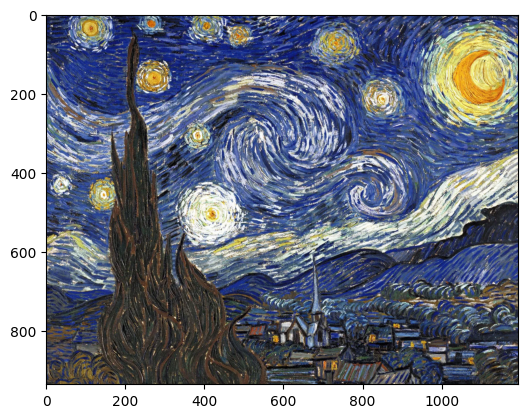

In [3]:

# Step 1: Load a real image
img_path = 'image.png'
image = Image.open(img_path).convert('RGB')



transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize to 224x224
    transforms.ToTensor(),            # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models, gives better results apparently
])

image_tensor = transform(image).unsqueeze(0)  #batch dimension (1, 3, 224, 224)


plt.imshow(image)

In [4]:

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Define a simple convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=24, stride=1, padding=1) # Basicall []224x224 -> []8x3x3, sride ra padding ta convolution ra cross correlation ko lagi vayo


    def forward(self, x):
        return self.conv1(x)

In [5]:

model = SimpleConvNet()
filters = model.conv1.weight.data  
print(f"Filter shape: {filters.shape}") 

Filter shape: torch.Size([8, 3, 24, 24])


In [6]:
def show_rgb_filters(filters):
    plt.figure(figsize=(10, 4))
    for i in range(filters.shape[0]):  # 8 filters
        filt = filters[i].cpu().numpy().transpose(1, 2, 0)  # (3, 3, 3) → (3, 3, 3)
        # Normalize to 0-1 for display
        filt = (filt - filt.min()) / (filt.max() - filt.min())
        plt.subplot(2, 4, i+1)
        plt.imshow(filt)
        plt.title(f"Filter {i+1}")
        plt.axis('off')
    plt.show()


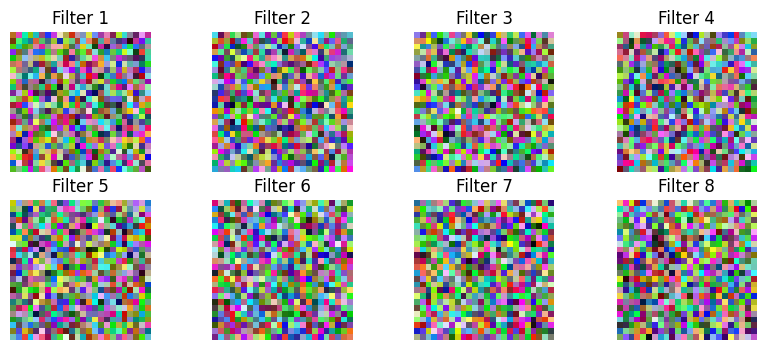

In [7]:
show_rgb_filters(filters)

Filters after forward pass shape: torch.Size([8, 3, 24, 24])


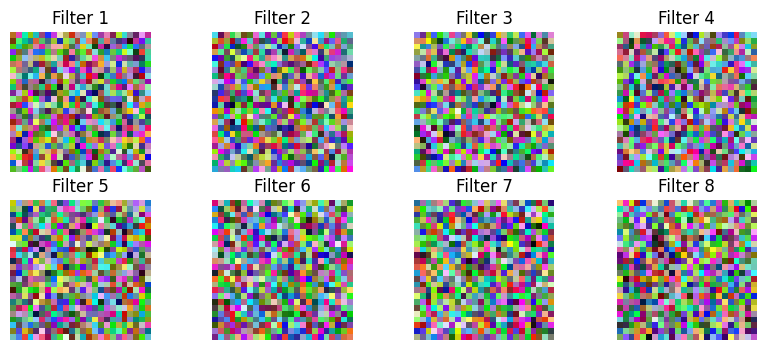

In [8]:

output = model(image_tensor)
filters_after_forward = model.conv1.weight.data
# The filters should remain aile lai ta
print(f"Filters after forward pass shape: {filters_after_forward.shape}")
show_rgb_filters(filters_after_forward)

## Session 2

We reconstruct
 the style of the input image from a style representation built on different subsets of CNN layers<br> ‘conv1 1’ (a), ‘conv1 1’ and ‘conv2 1’
 (b), ‘conv1 1’, ‘conv2 1’ and ‘conv3 1’ (c), ‘conv1 1’, ‘conv2 1’, ‘conv3 1’ and ‘conv4 1’ (d), ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’
 and ‘conv5 1’ (e). This creates images that match the style of a given image on an increasing scale while discarding information of the
 global arrangement of the scene<br><br> We used VGG instead of classical CNN's<br>Basically each layer of the network acts as filter bank<br>
 

## Session 3

The feature map at any point in the network can be reprseneted in a 2d matrix by flatterning each feature map into a 1d vector and stacking all of these 1d vectors to form a matrix<br>
To visualise the image information that is encoded at
 different layers of the hierarchy one can perform gradient
 descent on a white noise image to find another image that
 matches the feature responses of the original image <br><br>Along the process
ing hierarchy of the network, the input image is transformed
 into representations that are increasingly sensitive to the ac
tual content of the image, but become relatively invariant to
 its precise appearance.
<br><br>Thus, higher layers in the network
 capture the high-level content in terms of objects and their
 arrangement in the input image but do not constrain the ex
act pixel values of the reconstruction very much<br><br>We
 therefore refer to the feature responses in higher layers of
 the network as the content representation.<br><br>
 For style representation, we use gram matrix.<br> It consists of the cor
relations between the different filter responses, where the
 expectation is taken over the spatial extent of the feature
 maps.<br> By including the feature correlations of multiple layers, we
 obtain a stationary, multi-scale representation of the input
 image, which captures its texture information but not the
 global arrangement. 

## Session 4

haha hehe

## Session 5 (After a bit of break)

Recap of what i have done<br>
-> Got the vgg19 model<br>->Chose the style layers and content layers as specififed in the paper<br>->Wrote the required tarnsformation for the images<br>->Mechanism to extract the features and gram matrix as well<br>->Specified weights as specified in the paper<br>->"TRIED" to perform the transfer operation

In [9]:
import torchvision.models as models
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad=False
    

d:\Paper-Implementation\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Paper-Implementation\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
device = torch.device("cpu")
vgg = vgg.to(device)

In [11]:
content_layers = ['conv4_2']  # captures object structure
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']  # captures texture

content_layers = ['21']
style_layers = ['0', '5', '10', '19', '28'] 

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [13]:
def load_image(path):
    image = Image.open(path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)


In [14]:
def imshow(tensor, ax):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = image.clamp(0, 1)
    if ax!=0:
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
    else:
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.show()

        

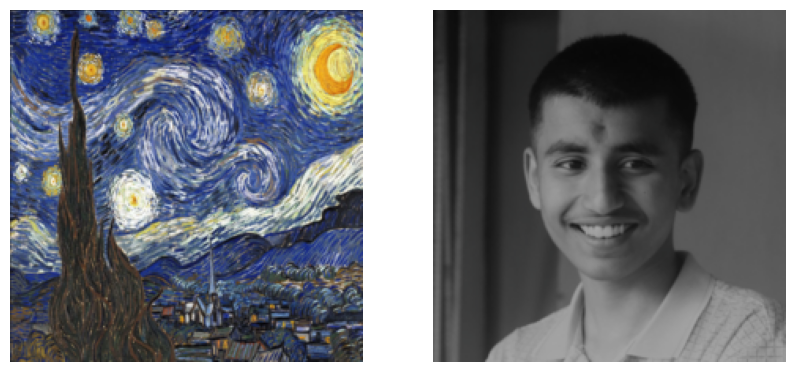

In [15]:
style_img = load_image("image.png")
content_img = load_image("target.png")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display images on respective axes
imshow(style_img, ax1)
imshow(content_img, ax2)

generated_img = content_img.clone().requires_grad_(True)

In [16]:
def get_features(x, model, layers):
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

In [17]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (c * h * w)

In [18]:
# Get feature mapsd
content_features = get_features(content_img, vgg, content_layers)
style_features = get_features(style_img, vgg, style_layers)

# Compute Gram
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Weights for each style layer
style_weights = {'0': 1.0, '5': 0.75, '10': 0.5, '19': 0.25, '28': 0.1}
content_weight = 1e4
style_weight = 1e2


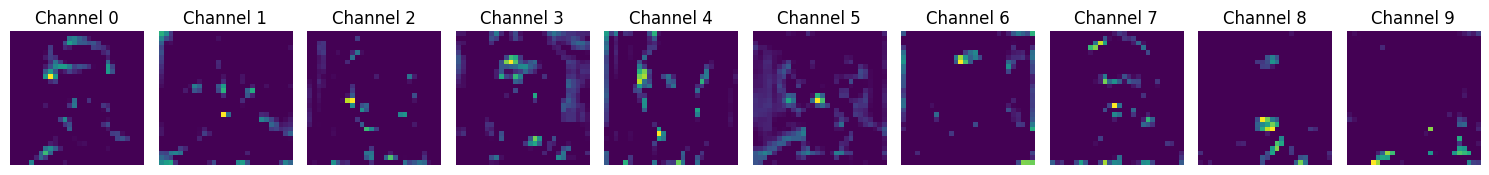

In [ ]:
feature_map = content_features["21"].squeeze(0)  # shape becomes (512, 28, 28)

num_channels_to_show = 10
fig, axes = plt.subplots(1, num_channels_to_show, figsize=(15, 5))

for i in range(num_channels_to_show):
    ax = axes[i]
    channel = feature_map[i].detach().cpu().numpy()
    ax.imshow(channel, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Channel {i}')

plt.tight_layout()
plt.show()

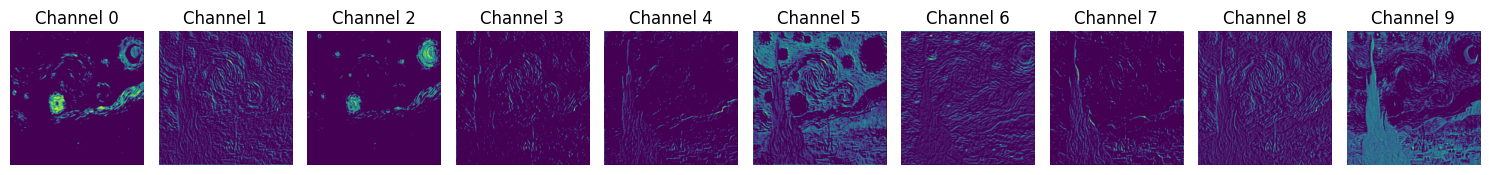

In [20]:
feature_map = style_features["0"].squeeze(0)

num_channels_to_show = 10
fig, axes = plt.subplots(1, num_channels_to_show, figsize=(15, 5))

for i in range(num_channels_to_show):
    ax = axes[i]
    channel = feature_map[i].detach().cpu().numpy()
    ax.imshow(channel, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Channel {i}')

plt.tight_layout()
plt.show()

In [21]:
optimizer = torch.optim.Adam([generated_img], lr=0.1)
steps = 10

for step in range(steps):
    generated_features = get_features(generated_img, vgg, style_layers + content_layers)

    # Content loss
    content_loss = torch.mean((generated_features['21'] - content_features['21']) ** 2)

    # Style loss
    style_loss = 0
    for layer in style_layers:
        gen_feat = generated_features[layer]
        gen_gram = gram_matrix(gen_feat)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((gen_gram - style_gram) ** 2)
        style_loss += layer_style_loss

    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item():.4f}")


Step 0, Total Loss: 0.0265


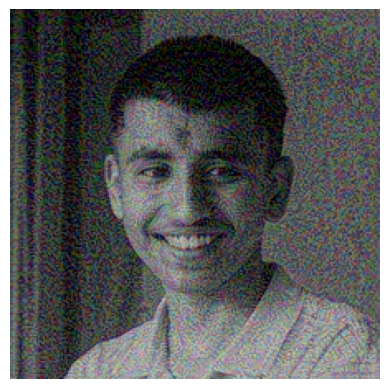

In [22]:
imshow(generated_img,0)